In [3]:
!pip install mplfinance
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 14.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 80.7 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.7-cp310-cp310-linux_x86_64.whl size=830296 sha256=49204e7eaee860b8d6d91c1d1766bc697cd327895c184c00dd9acbb1f4ee134c
  Stored in directory: /root/.cache/pip/wheels/8d/0e/f8/48eb93a200fca4c502d7590613616fa4d2c9533f7308f9e28a
Successfully built peewee


In [2]:
import datetime as dt

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import yfinance as yf
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential

In [3]:
# Load the dataset (using yfinance)
data = yf.download('AAPL', start='2018-01-01', end=dt.date.today())


[*********************100%***********************]  1 of 1 completed


In [4]:
# Calculate additional technical indicators
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['Label'] = np.where(data['SMA_5'] > data['SMA_10'], 1, 0)  # 1 for 'Up', 0 for 'Down'

# Prepare K-line data
k_line_data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
labels = data['Label'].dropna()

# Normalize K-line data
scaler = StandardScaler()
k_line_data_scaled = scaler.fit_transform(k_line_data)


# Define a function to create datasets for CNN
def create_cnn_dataset(data, labels, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(labels[i + look_back])
    return np.array(X), np.array(y)


look_back = 30  # N days of K-line data as input


In [5]:
# Create dataset for CNN
X, y = create_cnn_dataset(k_line_data_scaled, labels.values, look_back)

# Reshape X for CNN input
X = X.reshape(X.shape[0], look_back, 5, 1)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(look_back, 5, 1)))
model.add(MaxPooling2D((2, 1)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5560 - loss: 0.7065 - val_accuracy: 0.5858 - val_loss: 0.6718
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6031 - loss: 0.6705 - val_accuracy: 0.5858 - val_loss: 0.6655
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5834 - loss: 0.6783 - val_accuracy: 0.5858 - val_loss: 0.6642
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6311 - loss: 0.6588 - val_accuracy: 0.6183 - val_loss: 0.6621
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6161 - loss: 0.6564 - val_accuracy: 0.6065 - val_loss: 0.6592
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6182 - loss: 0.6553 - val_accuracy: 0.6213 - val_loss: 0.6619
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6608 - loss: 0.6393 - val_accuracy: 0.5976 - val_loss: 0.6550
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6327 - loss: 0.6366 - val_accuracy: 0.6243 - val_loss:

In [8]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int).reshape(-1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
print('Confusion Matrix:')
print(conf_matrix)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 0.81
Confusion Matrix:
[[ 94  46]
 [ 19 179]]


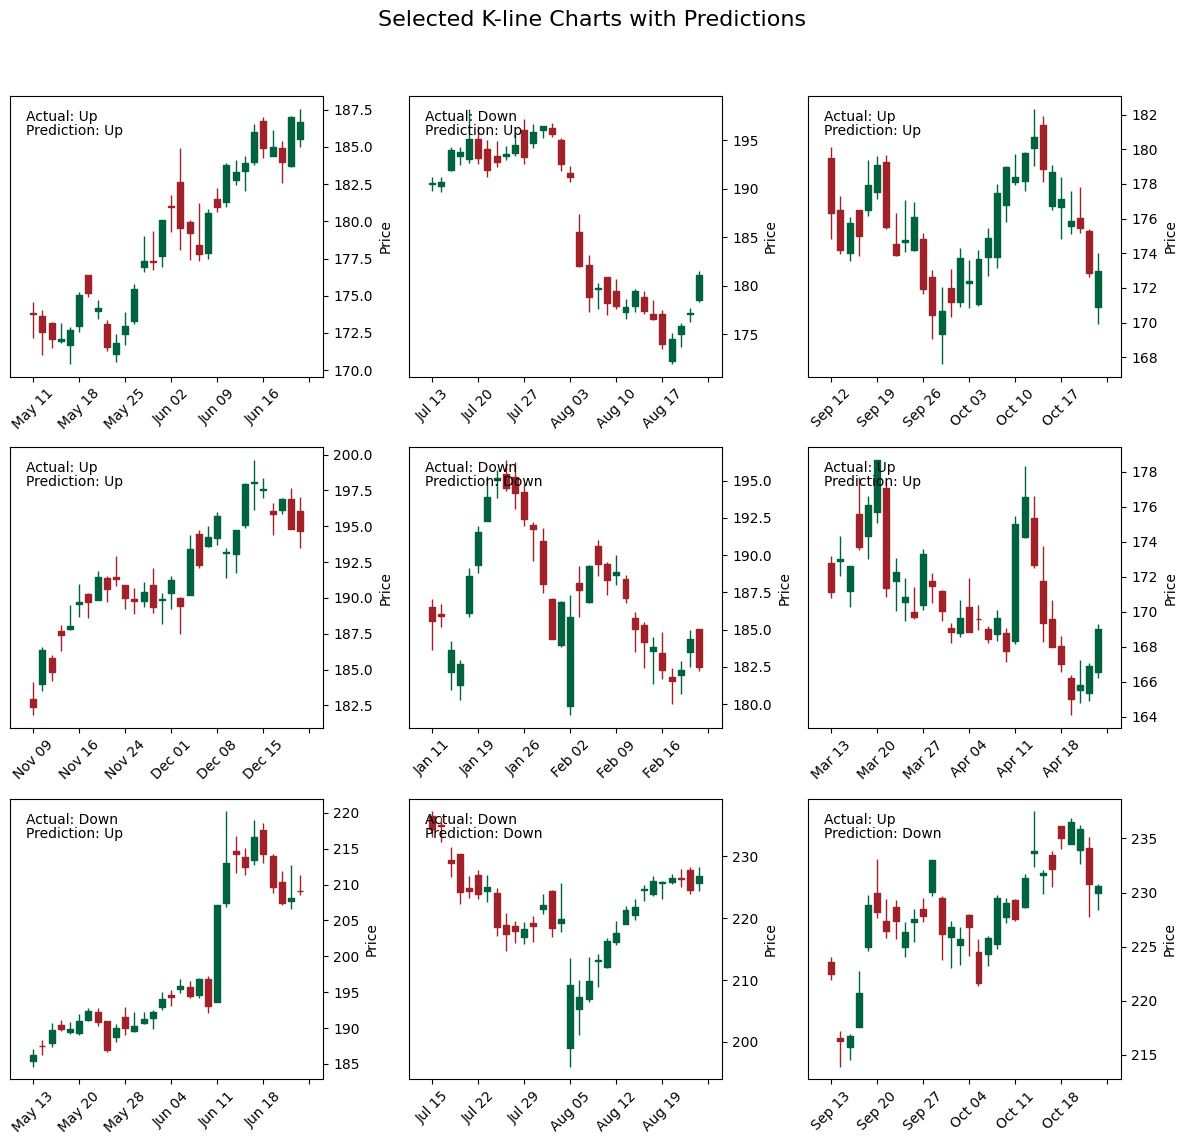

In [10]:
# Plot selected K-line (candlestick) charts with predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Selected K-line Charts with Predictions', fontsize=16)
selected_indices = np.linspace(0, len(y_test) - 1, 9, dtype=int)

for ax, i in zip(axes.flatten(), selected_indices):
    start_idx = len(data) - len(y_test) - look_back + i
    end_idx = start_idx + look_back
    sub_data = data.iloc[start_idx:end_idx]
    prediction = 'Up' if y_pred_labels[i] == 1 else 'Down'
    actual = 'Up' if y_test[i] == 1 else 'Down'

    mpf.plot(sub_data, type='candle', style='charles', volume=False, ax=ax, show_nontrading=False)
    ax.text(0.05, 0.95, f'Actual: {actual}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.text(0.05, 0.90, f'Prediction: {prediction}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
